# Simulating an inventory system

In this notebook we simulate an inventory system with stochastic demand. We perform the following steps:

* Investigate historic demand and assume a probability distribution that fits the data
* Use that probability distribution to generate demands for the simulation horizon
* Develop a simulation program for inventory system with a (*R* = 1, *S*) policy: a periodic inventory review policy in which we order up to the order-up-to level (OUL) *S* every *R* units of time (see picture below). The inventory level should cover the demand during the review period *R* and the lead time. Please note that in this case, inventory holdings costs then to be higher than for continuous review inventory systems.
* Optimize the parameter *S*.
* Simulate an (*R*, *s*, *S*) policy (picture given in part 5). In this policy, we order up to our OUL *S* only when the inventory level is lower than our re-order point (ROP) *s*.

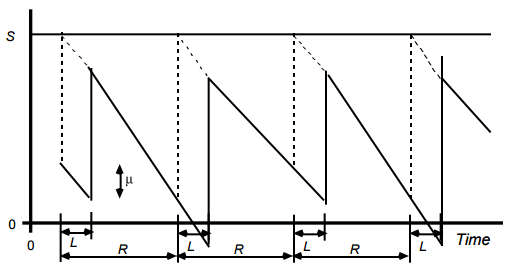
Source: https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FAbm-Abdul-Malek%2Fpublication%2F312286657%2Ffigure%2Ffig1%2FAS%3A449935045861376%401484284282406%2FR-S-Inventory-Policy.png&imgrefurl=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FR-S-Inventory-Policy_fig1_312286657&tbnid=XMNhdGPTthLpdM&vet=12ahUKEwjayPOUvfnzAhXSqqQKHVXbBuwQMygAegUIARCYAQ..i&docid=WT0NsnDDkWq0JM&w=509&h=274&q=R%2C%20s%2C%20S%20inventory&ved=2ahUKEwjayPOUvfnzAhXSqqQKHVXbBuwQMygAegUIARCYAQ

## Part 1: Investigate historic demand and assume a probability distribution that fits the data

In [2]:
#Import Pandas, read in the demand data, explore data
import pandas as pd
demand_data = pd.read_excel('./DemandData.xls', header = None, names = ['Weekly_demand'])
print(demand_data.head())
print(demand_data.dtypes)
print("Range of demand values: (", min(demand_data['Weekly_demand']), ",", max(demand_data['Weekly_demand']), ")")

   Weekly_demand
0     126.922249
1     100.919197
2     112.451675
3     162.802025
4      92.299140
Weekly_demand    float64
dtype: object
Range of demand values: ( 58.34177607969135 , 162.80202451940553 )


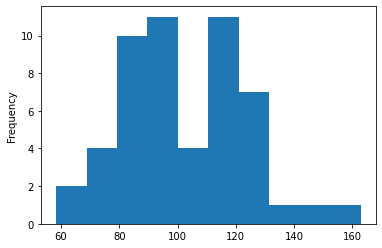

In [3]:
demand_data['Weekly_demand'].plot.hist()

We assume that the above distribution of demand data follows a normal distribution to simplify further analysis. We can thus generate further demand data from a normal distribution. We only need to calculate the mean and SD of the actual demand data to be able to do this.

In [4]:
m = demand_data['Weekly_demand'].mean()
sd = demand_data['Weekly_demand'].std()
print("Mean demand:", m, "\nStandard deviation of demand:", sd)

Mean demand: 102.54604117431717 
Standard deviation of demand: 21.21482595693871


## Part 2: How to use a normal distribution to generate demands for the simulation horizon

As an example, we now generate a full year of demand data to be added to the actual demand data we have, since one year of data is too exposed to the variance of a single year. Of course, we want our generated demand data to be non-negative, so we check for this.

In [5]:
import numpy as np

generated_demand_data = np.random.normal(loc = m, scale = sd, size = 52)
if any(generated_demand_data < 0) == True:
    generated_demand_data[generated_demand_data < 0] = 0
    print(generated_demand_data)
else:
    print("No non-negative demands observed")
    print(generated_demand_data)

print("Any non-negative demands:", any(generated_demand_data < 0))
print("Mean of new demand data:", generated_demand_data.mean())
print("Standard deviation of new demand data:", generated_demand_data.std())

No non-negative demands observed
[ 94.35439796 107.19566287  79.82124924 125.39400791 109.29284199
  55.26068376 103.63176765  83.45766974  96.3630736   63.83181046
 101.62167547  57.14280699 114.86958815  88.21045215 129.00889554
 106.61129018 122.6119684   95.17642783 114.56274466  81.88380946
  71.00557127 143.44374984 138.49086492 126.28369635  76.66730979
 111.06829098 101.08870564 142.69089192  89.75131542  99.08133689
  98.95953761 107.07821199  61.87798445 113.99052081 128.32533961
  88.04789227 106.23732851  89.69705212  73.69871238 106.53354804
  95.92428666 142.34144151 119.20047086 129.52348005 109.378659
  80.23576906 106.74633753 127.03113237 105.16651033  83.50868924
  89.46454393  66.22787552]
Any non-negative demands: False
Mean of new demand data: 101.1359592473809
Standard deviation of new demand data: 22.274844774191653


## Part 3: Develop a simulation program for inventory system with a (*R* = 1, *S*) policy

The following assumptions about inventory dynamics are made:
* Demand is stationary and independent normally distributed
* Lost sales model: demand not met from stock is lost
* Order lead time is 1 week
* Length of review period *R* is 1, so 1 week
* OUL level *S* is set to 256, equivalent to a 97.5% service level.

The following assumptions about cost structure are made:
* Unit holding costs are incurred for each item in stock at the start of a period (also for products received at the start of the period)
* Unit shortage costs are incurred for products that cannot be fulfilled from stock directly
* There is a fixed order cost per order

In the cell below, we create a function through which we can simulate the (R, S) policy. The following variables are declared:

*N* = number of runs

*T* = number of weeks

*S* = OUL

*k* = fixed order cost

*h* = unit holding cost per week

*u* = unit shortage cost

*alpha* = average fraction of weeks in which we are **not** out-of-stock, so in which we had enough inventory on-hand to fulfill all demand throughout the week (service level in fraction of weeks)

*beta* = average fraction of demand met directly from stock (service level in fraction of demand)

*avgcost* = average cost for a simulation run (1 year)

Now, we create a function of the cell above so we can use it to run simulations.

In [63]:
def SIMRS(N, T, S, k, h, u):

    alpha = []
    beta = []
    avgcost = []

    for run in range(N):
        I = np.full(T+1, 0) #Create empty array for on-hand inventory
        Q = np.full(T, 0) #Create empty array for order quantity values
        d = np.full(T, 0) #Create empty array for demand values
        Iend = np.full(T, 0) #Create empty array for end inventory
        #Each run starts with zero stock, so I[0] must always be 0
        NStockout = 0
        NShort = 0
        TC = 0 #initialize number of stockouts, units short, and total cost

        for week in range(T):
            Q[week] = S - I[week] #Order up to OUL level
            d[week] = max(0, np.random.normal(loc = m, scale = sd, size = 1)) #Generate random weekly demand
            Iend[week] = max(0, I[week] - d[week]) #Calculate inventory at end of week
            if week <= T:
                I[week+1] = Iend[week] + Q[week] #Orders delivered at end of the week
                if Iend[week] == 0: #Keep track of number of stockouts
                    NStockout = NStockout + 1
                if d[week] > I[week]: #Keep track of nr of units short
                    shortage = d[week] - I[week]
                else:
                    shortage = 0
                NShort = NShort + shortage
                if Q[week] > 0:
                    cost = k + h*I[week] + u*shortage
                else:
                    cost = h*I[week] + u*shortage
                TC = TC + cost
            else:
                break

        #Compute summary statistics for a run
        alpha.append(1-NStockout/T)
        beta.append(1-NShort/sum(d))
        avgcost.append(TC/T)
    
    avgalpha = np.mean(alpha)
    avgbeta = np.mean(beta)
    avgcost = np.mean(avgcost)
    print("Average cost per week over", N, "runs:", np.mean(avgcost))
    print("\nAverage fraction of weeks not out of stock over", N, "runs:", np.mean(alpha))
    print("\nAverage fraction of demand met from stock over", N, "runs:", np.mean(beta))
    
    return(alpha, beta, avgcost)

SIMRS(1, 52, 256, 25, 0.1, 1)

Average cost per week over 1 runs: 42.325

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9766026250713334
([0.9807692307692307], [0.9766026250713334], 42.325)
[0.9807692307692307]


Run simulations for OUL of 100, 200, and 400 and see what happens to the average cost, average fraction of weeks not out-of-stock, and the average fraction of demand met from stock (service level).

In [55]:
print("Results for OUL of 100\n")
SIMRS(1, 52, 100, 25, 0.1, 1)

Results for OUL of 100

Average cost over 1 runs: 78.01923076923077

Average fraction of weeks not out of stock over 1 runs: 0.09615384615384615

Average fraction of demand met from stock over 1 runs: 0.5038363171355499


In [56]:
print("Results for OUL of 200\n")
SIMRS(1, 52, 200, 25, 0.1, 1)

Results for OUL of 200

Average cost over 1 runs: 45.59807692307693

Average fraction of weeks not out of stock over 1 runs: 0.4807692307692307

Average fraction of demand met from stock over 1 runs: 0.8974069898534386


In [58]:
print("Results for OUL of 400\n")
SIMRS(1, 52, 400, 25, 0.1, 1)

Results for OUL of 400

Average cost over 1 runs: 56.084615384615375

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9777736617892202


What we see from the simulations above is that by setting the OUL higher, we increase the fraction of weeks we can fulfill demand from stock as well as the fraction of demand fulfilled directly from stock. Comparing the costs of OUL = 100 and OUL = 200, we see that the costs decrease, so setting OUL = 200 is more beneficial. However, even though OUL = 400 results in better alpha and beta values, our costs increase as well. So, we need to find the best value of S for our total costs.

## Part 4: Optimize the value of our OUL *S*

First, we perform an exploratory search for the best value of *S* by incrementing the value of *S* by 10 each time. Later, we perform a search towards the optimal value when we have an idea of the best range of *S*. We perform this search by searching through values starting from 10 up to the sum of annual demand from our actual demand data (in increments of 10).

In [75]:
annual_demand = int(round(sum(demand_data['Weekly_demand']), -1)) + 10
alpha_values = []
beta_values = []
avg_cost_values = []
for i in range(10, annual_demand, 10):
    x = SIMRS(1, 52, i, 25, 0.1, 1)
    alpha_values.append(x[0])
    beta_values.append(x[1])
    avg_cost_values.append(x[2])

Average cost per week over 1 runs: 108.15384615384616

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.049923195084485394
Average cost per week over 1 runs: 107.01923076923077

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.09660040869403674
Average cost per week over 1 runs: 105.34615384615384

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.1410488245931284
Average cost per week over 1 runs: 97.15384615384616

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.19482952416635446
Average cost per week over 1 runs: 89.86538461538461

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.25033699210475635
Average cost per week over 1 runs: 89.807692307

Average cost per week over 1 runs: 81.5326923076923

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9860448035255234
Average cost per week over 1 runs: 83.81153846153845

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9786085951050298
Average cost per week over 1 runs: 84.02692307692311

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9821727019498607
Average cost per week over 1 runs: 84.8692307692308

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9808170515097691
Average cost per week over 1 runs: 86.6096153846154

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.

Average cost per week over 1 runs: 151.36730769230772

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9862781954887218
Average cost per week over 1 runs: 152.5826923076923

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9833707025411061
Average cost per week over 1 runs: 154.7903846153846

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9735649546827795
Average cost per week over 1 runs: 154.79615384615383

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9801336799108801
Average cost per week over 1 runs: 156.46923076923073

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 ru


Average fraction of demand met from stock over 1 runs: 0.982933233308327
Average cost per week over 1 runs: 192.7211538461538

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9857549857549858
Average cost per week over 1 runs: 194.7192307692308

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9734882876339205
Average cost per week over 1 runs: 194.89423076923075

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9829250185597624
Average cost per week over 1 runs: 195.55192307692306

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9817213842058563
Average cost per week over 1 runs: 196.22115384615378

Average fraction of weeks not out of stock over 1 run

Average cost per week over 1 runs: 235.125

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9834964498176934
Average cost per week over 1 runs: 236.6423076923077

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9777274443186108
Average cost per week over 1 runs: 237.71730769230774

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9766747527523791
Average cost per week over 1 runs: 238.6865384615386

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9812860840135377
Average cost per week over 1 runs: 240.251923076923

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9731264

Average cost per week over 1 runs: 280.1557692307692

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9835483267900542
Average cost per week over 1 runs: 281.53076923076924

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9798732761833768
Average cost per week over 1 runs: 282.28076923076935

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9847923571846364
Average cost per week over 1 runs: 283.73653846153854

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9793595679012346
Average cost per week over 1 runs: 284.69615384615383

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 r

Average cost per week over 1 runs: 356.16346153846155

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.978405315614618
Average cost per week over 1 runs: 356.6365384615384

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9852716143840857
Average cost per week over 1 runs: 358.18846153846147

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9785915492957746
Average cost per week over 1 runs: 359.77884615384613

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9758539458186102
Average cost per week over 1 runs: 360.1961538461538

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 run

Average fraction of demand met from stock over 1 runs: 0.9834109972041006
Average cost per week over 1 runs: 396.48076923076917

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9831299353912419
Average cost per week over 1 runs: 398.3865384615384

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9803088803088803
Average cost per week over 1 runs: 399.49038461538464

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9788933257273246
Average cost per week over 1 runs: 400.26346153846157

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9803402646502836
Average cost per week over 1 runs: 401.4576923076923

Average fraction of weeks not out of stock over 1 run

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9804547267650578
Average cost per week over 1 runs: 438.6211538461538

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9763464337700145
Average cost per week over 1 runs: 440.80769230769226

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9726027397260274
Average cost per week over 1 runs: 439.9807692307694

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9825560044069042
Average cost per week over 1 runs: 440.91153846153844

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9833147942157954
Average cost per week over 1 run

Average cost per week over 1 runs: 478.6596153846155

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9775752051048313
Average cost per week over 1 runs: 479.03846153846155

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9864503816793894
Average cost per week over 1 runs: 480.6865384615385

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9822126661454261
Average cost per week over 1 runs: 481.71538461538455

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9800564440263405
Average cost per week over 1 runs: 482.70961538461535

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 ru

Average cost per week over 1 runs: 518.2538461538462

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9836936606815684
Average cost per week over 1 runs: 519.6057692307693

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9831279620853081
Average cost per week over 1 runs: 520.2019230769231

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9864916286149162
Average cost per week over 1 runs: 521.7961538461539

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9821463225305647
Average cost per week over 1 runs: 522.8692307692309

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs:

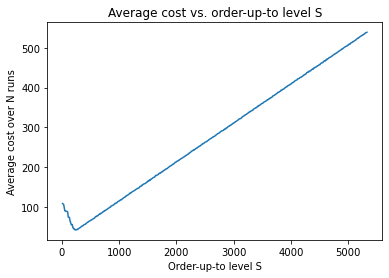

In [79]:
#Plot the average cost vs the order-up-to level S
import matplotlib.pyplot as plt
plt.plot(range(10, annual_demand, 10), avg_cost_values)
plt.title('Average cost vs. order-up-to level S')
plt.xlabel('Order-up-to level S')
plt.ylabel('Average cost over N runs')
plt.show()

We see clearly that there is a cost minimum at lower levels of *S*. We refine our search to be between 150 and 400 and run the simulation again.

In [82]:
alpha_values = []
beta_values = []
avg_cost_values = []
for i in range(10, 410, 10):
    x = SIMRS(1, 52, i, 25, 0.1, 1)
    alpha_values.append(x[0])
    beta_values.append(x[1])
    avg_cost_values.append(x[2])

Average cost per week over 1 runs: 110.84615384615384

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.04861630516080773
Average cost per week over 1 runs: 103.61538461538461

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.09988474836726857
Average cost per week over 1 runs: 104.57692307692308

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.14207650273224048
Average cost per week over 1 runs: 103.63461538461539

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.18325991189427315
Average cost per week over 1 runs: 90.5576923076923

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.24861350162554985
Average cost per week over 1 runs: 88.365384615

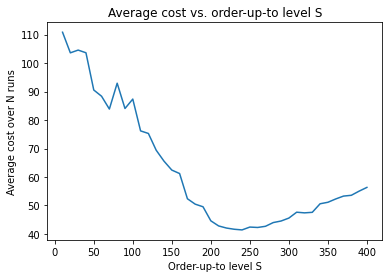

In [84]:
plt.plot(range(10, 410, 10), avg_cost_values)
plt.title('Average cost vs. order-up-to level S')
plt.xlabel('Order-up-to level S')
plt.ylabel('Average cost over N runs')
plt.show()

Minimum costs seem to be achieved somewhere between *S* = 200 and *S* = 250. We run the simulation again, now for values between 200 and 250 with increments of 1 to find the optimal value.

Note: our average costs per week seem to be robust for OUL level fluctuations between 200 and 250. This is good to see.

In [85]:
alpha_values = []
beta_values = []
avg_cost_values = []
for i in range(200, 251):
    x = SIMRS(1, 52, i, 25, 0.1, 1)
    alpha_values.append(x[0])
    beta_values.append(x[1])
    avg_cost_values.append(x[2])

Average cost per week over 1 runs: 43.31923076923076

Average fraction of weeks not out of stock over 1 runs: 0.5576923076923077

Average fraction of demand met from stock over 1 runs: 0.9178212184475233
Average cost per week over 1 runs: 46.103846153846156

Average fraction of weeks not out of stock over 1 runs: 0.5961538461538461

Average fraction of demand met from stock over 1 runs: 0.8940273357049242
Average cost per week over 1 runs: 45.51153846153847

Average fraction of weeks not out of stock over 1 runs: 0.4807692307692307

Average fraction of demand met from stock over 1 runs: 0.9007943838906336
Average cost per week over 1 runs: 44.611538461538466

Average fraction of weeks not out of stock over 1 runs: 0.6538461538461539

Average fraction of demand met from stock over 1 runs: 0.9089719626168224
Average cost per week over 1 runs: 45.83846153846155

Average fraction of weeks not out of stock over 1 runs: 0.5192307692307692

Average fraction of demand met from stock over 1 run

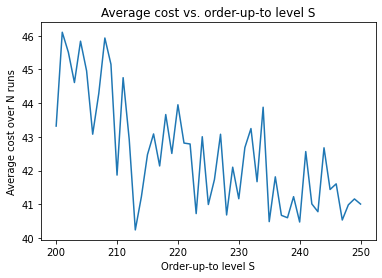

In [87]:
plt.plot(range(200, 251), avg_cost_values)
plt.title('Average cost vs. order-up-to level S')
plt.xlabel('Order-up-to level S')
plt.ylabel('Average cost over N runs')
plt.show()

In [110]:
#Find the minimum average cost value and its corresponding *S* value.
minimum = min(avg_cost_values)
print("Minimum cost:", minimum)
print("OUL S:", avg_cost_values.index(minimum) + 200 + 1)
print("Alpha at optimum:", alpha_values[avg_cost_values.index(minimum)])
print("Beta at optimum:", beta_values[avg_cost_values.index(minimum)])



Minimum cost: 40.23846153846154
OUL S: 214
Alpha at optimum: [0.8076923076923077]
Beta at optimum: [0.9599836668027767]


We have found that the minimal weekly cost is 40.24 with an OUL of 214. Thus, to achieve minimal costs, we should have an OUL of 214. At this point, we have do **not** stock out roughly 80.8% of the weeks, and we can fulfill roughly 96.0% of demand directly from stock.

## Part 5: Moving from (R = 1, S) to an (R = 1, s, S) policy

We now update our simulation model to include a parameter *s*, which represents the re-order point (ROP). We will only order up to *S* if our inventory level is below *s* at the review period. The picture below visualizes this policy (notation may be different).

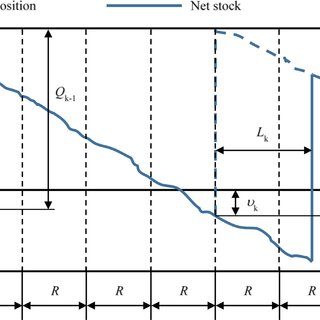
Source: https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FR-s-S-inventory-system_fig1_347397279&psig=AOvVaw38HM5kIgTJVb0msaQeEDT3&ust=1635935602361000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCKDU2Je9-fMCFQAAAAAdAAAAABAQ

First, we define the function with which we simulate the (R, s, S) policy.

In [113]:
def SIMRsS(N, T, S, s, k, h, u):

    alpha = []
    beta = []
    avgcost = []

    for run in range(N):
        I = np.full(T+1, 0) #Create empty array for on-hand inventory
        Q = np.full(T, 0) #Create empty array for order quantity values
        d = np.full(T, 0) #Create empty array for demand values
        Iend = np.full(T, 0) #Create empty array for end inventory
        #Each run starts with zero stock, so I[0] must always be 0
        NStockout = 0
        NShort = 0
        TC = 0 #initialize number of stockouts, units short, and total cost

        for week in range(T):
            if I[week] < s:
                Q[week] = S - I[week] #Order up to OUL level in we are past our ROP
            else:
                Q[week] = 0
            d[week] = max(0, np.random.normal(loc = m, scale = sd, size = 1)) #Generate random weekly demand
            Iend[week] = max(0, I[week] - d[week]) #Calculate inventory at end of week
            if week <= T:
                I[week+1] = Iend[week] + Q[week] #Orders delivered at end of the week
                if Iend[week] == 0: #Keep track of number of stockouts
                    NStockout = NStockout + 1
                if d[week] > I[week]: #Keep track of nr of units short
                    shortage = d[week] - I[week]
                else:
                    shortage = 0
                NShort = NShort + shortage
                if Q[week] > 0:
                    cost = k + h*I[week] + u*shortage
                else:
                    cost = h*I[week] + u*shortage
                TC = TC + cost
            else:
                break

        #Compute summary statistics for a run
        alpha.append(1-NStockout/T)
        beta.append(1-NShort/sum(d))
        avgcost.append(TC/T)
    
    avgalpha = np.mean(alpha)
    avgbeta = np.mean(beta)
    avgcost = np.mean(avgcost)
    print("Average cost per week over", N, "runs:", np.mean(avgcost))
    print("\nAverage fraction of weeks not out of stock over", N, "runs:", np.mean(alpha))
    print("\nAverage fraction of demand met from stock over", N, "runs:", np.mean(beta))
    
    return(alpha, beta, avgcost)

SIMRsS(1, 52, 256, 356, 25, 0.1, 1)

Average cost per week over 1 runs: 42.786538461538456

Average fraction of weeks not out of stock over 1 runs: 0.9230769230769231

Average fraction of demand met from stock over 1 runs: 0.9747832939322301


([0.9230769230769231], [0.9747832939322301], 42.786538461538456)

Now, we once again want to find the best value of *S*, but during these runs we also want to find the best value of *s*. We do so with increments of 10 again.

We saw in our previous optimization of *S* that the costs increase linearly after *S* = ±400. So, we limit our values of *S* to 600 for this search, and our value of *s* to 600 as well. This means we have to run 3600 simulations instead of ±270.000.

In [117]:
best_cost = 999999999999999
best_alpha = 0
best_beta = 0
best_s = 0
best_S = 0
for i in range(10, 610, 10):
    for j in range(10, 610, 10):
        x = SIMRsS(1, 52, i, j, 25, 0.1, 1)
        if x[2] < best_cost:
            best_cost = x[2]
            best_alpha = x[0]
            best_beta = x[1]
            best_s = j
            best_S = i

Average cost per week over 1 runs: 107.32692307692308

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.0503388189738625
Average cost per week over 1 runs: 109.5576923076923

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.04923309979170609
Average cost per week over 1 runs: 113.26923076923077

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.04749725977347463
Average cost per week over 1 runs: 112.21153846153847

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.047979331980070095
Average cost per week over 1 runs: 106.82692307692308

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.05059350068106638
Average cost per week over 1 runs: 109.4038461

Average cost per week over 1 runs: 104.13461538461539

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.09936938658513284
Average cost per week over 1 runs: 109.75

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.09411764705882353
Average cost per week over 1 runs: 103.36538461538461

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.10013479684190252
Average cost per week over 1 runs: 102.48076923076923

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.10102972605401206
Average cost per week over 1 runs: 105.03846153846153

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.09848484848484851
Average cost per week over 1 runs: 106.28846153846153

Av

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.15034695451040858
Average cost per week over 1 runs: 100.86538461538461

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.14725316216726447
Average cost per week over 1 runs: 105.82692307692308

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.14041404140414038
Average cost per week over 1 runs: 101.25

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.1466992665036675
Average cost per week over 1 runs: 102.13461538461539

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.14544098452358756
Average cost per week over 1 runs: 100.38461538461539

Average fraction of weeks not out of stock over 1 runs: 0.

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.19399365789964562
Average cost per week over 1 runs: 104.36538461538461

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.18204095921582353
Average cost per week over 1 runs: 93.15384615384616

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.20272904483430798
Average cost per week over 1 runs: 94.28846153846153

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.20042397379071109
Average cost per week over 1 runs: 93.63461538461539

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.2017458777885548
Average cost per week over 1 runs: 96.01923076923077

Average fraction of weeks not out of stock over 1 

Average fraction of demand met from stock over 1 runs: 0.2884866579585743
Average cost per week over 1 runs: 103.32692307692308

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock over 1 runs: 0.28301200436522367
Average cost per week over 1 runs: 85.67307692307692

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock over 1 runs: 0.31037260825780466
Average cost per week over 1 runs: 93.76923076923077

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock over 1 runs: 0.2844103687477182
Average cost per week over 1 runs: 91.15384615384616

Average fraction of weeks not out of stock over 1 runs: 0.0

Average fraction of demand met from stock over 1 runs: 0.28394612304332
Average cost per week over 1 runs: 91.4423076923077

Average fraction of weeks not out of stock over 1 runs: 0.0

Aver

Average cost per week over 1 runs: 89.61538461538461

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock over 1 runs: 0.33811475409836067
Average cost per week over 1 runs: 90.09615384615384

Average fraction of weeks not out of stock over 1 runs: 0.05769230769230771

Average fraction of demand met from stock over 1 runs: 0.3469583573210516
Average cost per week over 1 runs: 85.67307692307692

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock over 1 runs: 0.33525581395348836
Average cost per week over 1 runs: 81.8076923076923

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock over 1 runs: 0.35016380805550207
Average cost per week over 1 runs: 92.53846153846153

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock o

Average fraction of demand met from stock over 1 runs: 0.3930197268588771
Average cost per week over 1 runs: 88.8076923076923

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock over 1 runs: 0.3933333333333333
Average cost per week over 1 runs: 96.23076923076923

Average fraction of weeks not out of stock over 1 runs: 0.038461538461538436

Average fraction of demand met from stock over 1 runs: 0.3685437589670014
Average cost per week over 1 runs: 90.23076923076923

Average fraction of weeks not out of stock over 1 runs: 0.038461538461538436

Average fraction of demand met from stock over 1 runs: 0.3838649155722327
Average cost per week over 1 runs: 90.42307692307692

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock over 1 runs: 0.3789004457652303
Average cost per week over 1 runs: 86.34615384615384

Average fraction of weeks not out of stock over 1

Average fraction of weeks not out of stock over 1 runs: 0.13461538461538458

Average fraction of demand met from stock over 1 runs: 0.3920810313075507
Average cost per week over 1 runs: 78.5576923076923

Average fraction of weeks not out of stock over 1 runs: 0.17307692307692313

Average fraction of demand met from stock over 1 runs: 0.41233706627501376
Average cost per week over 1 runs: 70.13461538461539

Average fraction of weeks not out of stock over 1 runs: 0.11538461538461542

Average fraction of demand met from stock over 1 runs: 0.45091414944356123
Average cost per week over 1 runs: 76.0

Average fraction of weeks not out of stock over 1 runs: 0.11538461538461542

Average fraction of demand met from stock over 1 runs: 0.4280387770320656
Average cost per week over 1 runs: 74.73076923076923

Average fraction of weeks not out of stock over 1 runs: 0.15384615384615385

Average fraction of demand met from stock over 1 runs: 0.4302524198140064
Average cost per week over 1 runs: 71.788

Average cost per week over 1 runs: 87.3076923076923

Average fraction of weeks not out of stock over 1 runs: 0.038461538461538436

Average fraction of demand met from stock over 1 runs: 0.4249770431588613
Average cost per week over 1 runs: 85.36538461538461

Average fraction of weeks not out of stock over 1 runs: 0.05769230769230771

Average fraction of demand met from stock over 1 runs: 0.4385331559946798
Average cost per week over 1 runs: 84.67307692307692

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 runs: 0.4343472510863404
Average cost per week over 1 runs: 81.88461538461539

Average fraction of weeks not out of stock over 1 runs: 0.019230769230769273

Average fraction of demand met from stock over 1 runs: 0.44324947186479735
Average cost per week over 1 runs: 82.0576923076923

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1

Average cost per week over 1 runs: 86.34615384615384

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 runs: 0.4612185861507865
Average cost per week over 1 runs: 80.0576923076923

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 runs: 0.47889701744513224
Average cost per week over 1 runs: 77.61538461538461

Average fraction of weeks not out of stock over 1 runs: 0.05769230769230771

Average fraction of demand met from stock over 1 runs: 0.49912502430488037
Average cost per week over 1 runs: 82.90384615384616

Average fraction of weeks not out of stock over 1 runs: 0.05769230769230771

Average fraction of demand met from stock over 1 runs: 0.4805389221556886
Average cost per week over 1 runs: 78.53846153846153

Average fraction of weeks not out of stock over 1 runs: 0.038461538461538436

Average fraction of demand met from stock over 

Average cost per week over 1 runs: 73.64423076923077

Average fraction of weeks not out of stock over 1 runs: 0.11538461538461542

Average fraction of demand met from stock over 1 runs: 0.5430243902439025
Average cost per week over 1 runs: 76.4423076923077

Average fraction of weeks not out of stock over 1 runs: 0.11538461538461542

Average fraction of demand met from stock over 1 runs: 0.5390490738972694
Average cost per week over 1 runs: 75.38461538461539

Average fraction of weeks not out of stock over 1 runs: 0.05769230769230771

Average fraction of demand met from stock over 1 runs: 0.5438901778808971
Average cost per week over 1 runs: 75.75

Average fraction of weeks not out of stock over 1 runs: 0.11538461538461542

Average fraction of demand met from stock over 1 runs: 0.542164035425491
Average cost per week over 1 runs: 76.1923076923077

Average fraction of weeks not out of stock over 1 runs: 0.09615384615384615

Average fraction of demand met from stock over 1 runs: 0.5395090

Average cost per week over 1 runs: 69.47115384615384

Average fraction of weeks not out of stock over 1 runs: 0.25

Average fraction of demand met from stock over 1 runs: 0.5076151560178306
Average cost per week over 1 runs: 67.88461538461539

Average fraction of weeks not out of stock over 1 runs: 0.28846153846153844

Average fraction of demand met from stock over 1 runs: 0.5216328066215199
Average cost per week over 1 runs: 64.98076923076923

Average fraction of weeks not out of stock over 1 runs: 0.17307692307692313

Average fraction of demand met from stock over 1 runs: 0.5834340991535671
Average cost per week over 1 runs: 71.21153846153847

Average fraction of weeks not out of stock over 1 runs: 0.05769230769230771

Average fraction of demand met from stock over 1 runs: 0.5806207418622256
Average cost per week over 1 runs: 74.48076923076923

Average fraction of weeks not out of stock over 1 runs: 0.13461538461538458

Average fraction of demand met from stock over 1 runs: 0.5535190

Average cost per week over 1 runs: 71.84615384615384

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 runs: 0.6107444077741108
Average cost per week over 1 runs: 67.32692307692308

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 runs: 0.6372021521906226
Average cost per week over 1 runs: 68.86730769230769

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 runs: 0.627766219027804
Average cost per week over 1 runs: 66.42692307692309

Average fraction of weeks not out of stock over 1 runs: 0.09615384615384615

Average fraction of demand met from stock over 1 runs: 0.6386032977691561
Average cost per week over 1 runs: 66.82692307692308

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 r

Average cost per week over 1 runs: 64.68846153846154

Average fraction of weeks not out of stock over 1 runs: 0.13461538461538458

Average fraction of demand met from stock over 1 runs: 0.6732410392565902
Average cost per week over 1 runs: 68.82692307692308

Average fraction of weeks not out of stock over 1 runs: 0.05769230769230771

Average fraction of demand met from stock over 1 runs: 0.6484233417905039
Average cost per week over 1 runs: 65.07307692307693

Average fraction of weeks not out of stock over 1 runs: 0.05769230769230771

Average fraction of demand met from stock over 1 runs: 0.6707593502077824
Average cost per week over 1 runs: 74.38461538461539

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 runs: 0.6146265560165975
Average cost per week over 1 runs: 63.80576923076922

Average fraction of weeks not out of stock over 1 runs: 0.17307692307692313

Average fraction of demand met from stock over 1 

Average cost per week over 1 runs: 61.46153846153846

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 runs: 0.7137247569184741
Average cost per week over 1 runs: 60.35961538461538

Average fraction of weeks not out of stock over 1 runs: 0.11538461538461542

Average fraction of demand met from stock over 1 runs: 0.7214758751182593
Average cost per week over 1 runs: 65.6

Average fraction of weeks not out of stock over 1 runs: 0.11538461538461542

Average fraction of demand met from stock over 1 runs: 0.6858016915601943
Average cost per week over 1 runs: 65.67307692307692

Average fraction of weeks not out of stock over 1 runs: 0.07692307692307687

Average fraction of demand met from stock over 1 runs: 0.6860423394330821
Average cost per week over 1 runs: 61.861538461538466

Average fraction of weeks not out of stock over 1 runs: 0.15384615384615385

Average fraction of demand met from stock over 1 runs: 0.7086

Average cost per week over 1 runs: 58.794230769230765

Average fraction of weeks not out of stock over 1 runs: 0.15384615384615385

Average fraction of demand met from stock over 1 runs: 0.7480140402734159
Average cost per week over 1 runs: 58.119230769230775

Average fraction of weeks not out of stock over 1 runs: 0.17307692307692313

Average fraction of demand met from stock over 1 runs: 0.7525657771972383
Average cost per week over 1 runs: 54.10384615384617

Average fraction of weeks not out of stock over 1 runs: 0.3076923076923077

Average fraction of demand met from stock over 1 runs: 0.7814530419373893
Average cost per week over 1 runs: 60.27884615384615

Average fraction of weeks not out of stock over 1 runs: 0.09615384615384615

Average fraction of demand met from stock over 1 runs: 0.7378004369992717
Average cost per week over 1 runs: 59.532692307692315

Average fraction of weeks not out of stock over 1 runs: 0.17307692307692313

Average fraction of demand met from stock over 

Average cost per week over 1 runs: 52.21153846153847

Average fraction of weeks not out of stock over 1 runs: 0.2692307692307693

Average fraction of demand met from stock over 1 runs: 0.8118004173781066
Average cost per week over 1 runs: 51.14423076923077

Average fraction of weeks not out of stock over 1 runs: 0.3846153846153846

Average fraction of demand met from stock over 1 runs: 0.8185918807609335
Average cost per week over 1 runs: 54.965384615384615

Average fraction of weeks not out of stock over 1 runs: 0.25

Average fraction of demand met from stock over 1 runs: 0.7888639760837071
Average cost per week over 1 runs: 57.96346153846154

Average fraction of weeks not out of stock over 1 runs: 0.23076923076923073

Average fraction of demand met from stock over 1 runs: 0.7679856115107914
Average cost per week over 1 runs: 48.940384615384616

Average fraction of weeks not out of stock over 1 runs: 0.3846153846153846

Average fraction of demand met from stock over 1 runs: 0.8378
Ave

Average cost per week over 1 runs: 49.48846153846153

Average fraction of weeks not out of stock over 1 runs: 0.25

Average fraction of demand met from stock over 1 runs: 0.845648912228057
Average cost per week over 1 runs: 52.157692307692315

Average fraction of weeks not out of stock over 1 runs: 0.34615384615384615

Average fraction of demand met from stock over 1 runs: 0.8229957415293464
Average cost per week over 1 runs: 48.22692307692307

Average fraction of weeks not out of stock over 1 runs: 0.4423076923076923

Average fraction of demand met from stock over 1 runs: 0.8540391072486668
Average cost per week over 1 runs: 48.900000000000006

Average fraction of weeks not out of stock over 1 runs: 0.46153846153846156

Average fraction of demand met from stock over 1 runs: 0.8493361554743121
Average cost per week over 1 runs: 50.94615384615386

Average fraction of weeks not out of stock over 1 runs: 0.3076923076923077

Average fraction of demand met from stock over 1 runs: 0.83351955

Average fraction of demand met from stock over 1 runs: 0.8812873386008865
Average cost per week over 1 runs: 46.17115384615384

Average fraction of weeks not out of stock over 1 runs: 0.3846153846153846

Average fraction of demand met from stock over 1 runs: 0.883298259039602
Average cost per week over 1 runs: 49.21153846153846

Average fraction of weeks not out of stock over 1 runs: 0.40384615384615385

Average fraction of demand met from stock over 1 runs: 0.8582619785024594
Average cost per week over 1 runs: 47.67307692307692

Average fraction of weeks not out of stock over 1 runs: 0.42307692307692313

Average fraction of demand met from stock over 1 runs: 0.8698681732580038
Average cost per week over 1 runs: 46.08653846153846

Average fraction of weeks not out of stock over 1 runs: 0.5576923076923077

Average fraction of demand met from stock over 1 runs: 0.8835443037974684
Average cost per week over 1 runs: 47.89423076923077

Average fraction of weeks not out of stock over 1 runs:

Average cost per week over 1 runs: 51.607692307692304

Average fraction of weeks not out of stock over 1 runs: 0.5

Average fraction of demand met from stock over 1 runs: 0.7233252922620153
Average cost per week over 1 runs: 50.20384615384615

Average fraction of weeks not out of stock over 1 runs: 0.4807692307692307

Average fraction of demand met from stock over 1 runs: 0.7738424644899465
Average cost per week over 1 runs: 47.46923076923077

Average fraction of weeks not out of stock over 1 runs: 0.4807692307692307

Average fraction of demand met from stock over 1 runs: 0.7938989513822688
Average cost per week over 1 runs: 44.18846153846153

Average fraction of weeks not out of stock over 1 runs: 0.5384615384615384

Average fraction of demand met from stock over 1 runs: 0.9002854424357755
Average cost per week over 1 runs: 43.551923076923075

Average fraction of weeks not out of stock over 1 runs: 0.5961538461538461

Average fraction of demand met from stock over 1 runs: 0.9157671549

Average cost per week over 1 runs: 45.615384615384606

Average fraction of weeks not out of stock over 1 runs: 0.46153846153846156

Average fraction of demand met from stock over 1 runs: 0.8971578160059835
Average cost per week over 1 runs: 43.06346153846154

Average fraction of weeks not out of stock over 1 runs: 0.4807692307692307

Average fraction of demand met from stock over 1 runs: 0.9204244031830239
Average cost per week over 1 runs: 47.43076923076923

Average fraction of weeks not out of stock over 1 runs: 0.5192307692307692

Average fraction of demand met from stock over 1 runs: 0.8829576194770064
Average cost per week over 1 runs: 46.26923076923077

Average fraction of weeks not out of stock over 1 runs: 0.5961538461538461

Average fraction of demand met from stock over 1 runs: 0.8920700696929742
Average cost per week over 1 runs: 42.79807692307692

Average fraction of weeks not out of stock over 1 runs: 0.5769230769230769

Average fraction of demand met from stock over 1 run

Average cost per week over 1 runs: 44.89423076923076

Average fraction of weeks not out of stock over 1 runs: 0.5961538461538461

Average fraction of demand met from stock over 1 runs: 0.912828947368421
Average cost per week over 1 runs: 45.925000000000004

Average fraction of weeks not out of stock over 1 runs: 0.4423076923076923

Average fraction of demand met from stock over 1 runs: 0.9039239838113673
Average cost per week over 1 runs: 42.14423076923076

Average fraction of weeks not out of stock over 1 runs: 0.6153846153846154

Average fraction of demand met from stock over 1 runs: 0.9372742824558069
Average cost per week over 1 runs: 41.73076923076923

Average fraction of weeks not out of stock over 1 runs: 0.8076923076923077

Average fraction of demand met from stock over 1 runs: 0.9418490045338064
Average cost per week over 1 runs: 44.24615384615384

Average fraction of weeks not out of stock over 1 runs: 0.6153846153846154

Average fraction of demand met from stock over 1 runs:

Average cost per week over 1 runs: 44.036538461538434

Average fraction of weeks not out of stock over 1 runs: 0.6923076923076923

Average fraction of demand met from stock over 1 runs: 0.9281172730483928
Average cost per week over 1 runs: 43.10192307692308

Average fraction of weeks not out of stock over 1 runs: 0.6730769230769231

Average fraction of demand met from stock over 1 runs: 0.9365746664229574
Average cost per week over 1 runs: 42.56346153846155

Average fraction of weeks not out of stock over 1 runs: 0.75

Average fraction of demand met from stock over 1 runs: 0.9414571481005689
Average cost per week over 1 runs: 41.75769230769231

Average fraction of weeks not out of stock over 1 runs: 0.8269230769230769

Average fraction of demand met from stock over 1 runs: 0.9499806875241406
Average cost per week over 1 runs: 42.74615384615385

Average fraction of weeks not out of stock over 1 runs: 0.6730769230769231

Average fraction of demand met from stock over 1 runs: 0.9398181818

Average cost per week over 1 runs: 47.849999999999994

Average fraction of weeks not out of stock over 1 runs: 0.5576923076923077

Average fraction of demand met from stock over 1 runs: 0.7424819185382565
Average cost per week over 1 runs: 44.236538461538444

Average fraction of weeks not out of stock over 1 runs: 0.5961538461538461

Average fraction of demand met from stock over 1 runs: 0.7928490351872872
Average cost per week over 1 runs: 43.11346153846153

Average fraction of weeks not out of stock over 1 runs: 0.5576923076923077

Average fraction of demand met from stock over 1 runs: 0.8078577013291635
Average cost per week over 1 runs: 43.88653846153847

Average fraction of weeks not out of stock over 1 runs: 0.5769230769230769

Average fraction of demand met from stock over 1 runs: 0.8308977035490606
Average cost per week over 1 runs: 42.39423076923076

Average fraction of weeks not out of stock over 1 runs: 0.6346153846153846

Average fraction of demand met from stock over 1 run

Average cost per week over 1 runs: 40.77692307692307

Average fraction of weeks not out of stock over 1 runs: 0.8269230769230769

Average fraction of demand met from stock over 1 runs: 0.9681712962962963
Average cost per week over 1 runs: 42.815384615384616

Average fraction of weeks not out of stock over 1 runs: 0.7115384615384616

Average fraction of demand met from stock over 1 runs: 0.9477926360139219
Average cost per week over 1 runs: 40.75192307692308

Average fraction of weeks not out of stock over 1 runs: 0.9038461538461539

Average fraction of demand met from stock over 1 runs: 0.9677234530175707
Average cost per week over 1 runs: 41.588461538461544

Average fraction of weeks not out of stock over 1 runs: 0.8076923076923077

Average fraction of demand met from stock over 1 runs: 0.9610113877629801
Average cost per week over 1 runs: 40.76346153846154

Average fraction of weeks not out of stock over 1 runs: 0.8461538461538461

Average fraction of demand met from stock over 1 run

Average cost per week over 1 runs: 49.83076923076922

Average fraction of weeks not out of stock over 1 runs: 0.5576923076923077

Average fraction of demand met from stock over 1 runs: 0.7192099869573318
Average cost per week over 1 runs: 49.755769230769225

Average fraction of weeks not out of stock over 1 runs: 0.5384615384615384

Average fraction of demand met from stock over 1 runs: 0.7280782721063319
Average cost per week over 1 runs: 46.348076923076924

Average fraction of weeks not out of stock over 1 runs: 0.5769230769230769

Average fraction of demand met from stock over 1 runs: 0.7648735981752519
Average cost per week over 1 runs: 46.040384615384625

Average fraction of weeks not out of stock over 1 runs: 0.5769230769230769

Average fraction of demand met from stock over 1 runs: 0.7863828225362453
Average cost per week over 1 runs: 42.81538461538461

Average fraction of weeks not out of stock over 1 runs: 0.6538461538461539

Average fraction of demand met from stock over 1 ru

Average cost per week over 1 runs: 39.41730769230769

Average fraction of weeks not out of stock over 1 runs: 0.6538461538461539

Average fraction of demand met from stock over 1 runs: 0.8609372035666856
Average cost per week over 1 runs: 41.93846153846153

Average fraction of weeks not out of stock over 1 runs: 0.6153846153846154

Average fraction of demand met from stock over 1 runs: 0.8377719429857464
Average cost per week over 1 runs: 38.60769230769232

Average fraction of weeks not out of stock over 1 runs: 0.6730769230769231

Average fraction of demand met from stock over 1 runs: 0.8719500662001135
Average cost per week over 1 runs: 38.653846153846146

Average fraction of weeks not out of stock over 1 runs: 0.7115384615384616

Average fraction of demand met from stock over 1 runs: 0.8844279867472228
Average cost per week over 1 runs: 41.36346153846155

Average fraction of weeks not out of stock over 1 runs: 0.6923076923076923

Average fraction of demand met from stock over 1 runs

Average cost per week over 1 runs: 44.20192307692308

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9724401913875598
Average cost per week over 1 runs: 43.19038461538461

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9815242494226328
Average cost per week over 1 runs: 43.29423076923077

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.979499717886026
Average cost per week over 1 runs: 43.01923076923078

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9851924975320829
Average cost per week over 1 runs: 42.60000000000001

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 

Average cost per week over 1 runs: 43.72884615384615

Average fraction of weeks not out of stock over 1 runs: 0.6153846153846154

Average fraction of demand met from stock over 1 runs: 0.8026731019120104
Average cost per week over 1 runs: 39.401923076923076

Average fraction of weeks not out of stock over 1 runs: 0.6346153846153846

Average fraction of demand met from stock over 1 runs: 0.8629959213941416
Average cost per week over 1 runs: 38.88076923076923

Average fraction of weeks not out of stock over 1 runs: 0.6153846153846154

Average fraction of demand met from stock over 1 runs: 0.8722964077487305
Average cost per week over 1 runs: 43.04423076923077

Average fraction of weeks not out of stock over 1 runs: 0.6730769230769231

Average fraction of demand met from stock over 1 runs: 0.8289956011730205
Average cost per week over 1 runs: 41.6653846153846

Average fraction of weeks not out of stock over 1 runs: 0.6923076923076923

Average fraction of demand met from stock over 1 runs:

Average fraction of weeks not out of stock over 1 runs: 0.5769230769230769

Average fraction of demand met from stock over 1 runs: 0.7362678009987054
Average cost per week over 1 runs: 46.77307692307692

Average fraction of weeks not out of stock over 1 runs: 0.6346153846153846

Average fraction of demand met from stock over 1 runs: 0.7774740295243302
Average cost per week over 1 runs: 45.48269230769232

Average fraction of weeks not out of stock over 1 runs: 0.6538461538461539

Average fraction of demand met from stock over 1 runs: 0.7805613109813524
Average cost per week over 1 runs: 39.23846153846153

Average fraction of weeks not out of stock over 1 runs: 0.7115384615384616

Average fraction of demand met from stock over 1 runs: 0.8512670565302144
Average cost per week over 1 runs: 38.26538461538461

Average fraction of weeks not out of stock over 1 runs: 0.6538461538461539

Average fraction of demand met from stock over 1 runs: 0.8787427933792078
Average cost per week over 1 runs:

Average cost per week over 1 runs: 45.109615384615374

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9787351054078827
Average cost per week over 1 runs: 44.853846153846156

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9814474650991918
Average cost per week over 1 runs: 45.47499999999998

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9786218744035121
Average cost per week over 1 runs: 44.96346153846154

Average fraction of weeks not out of stock over 1 runs: 0.9423076923076923

Average fraction of demand met from stock over 1 runs: 0.9805771365149833
Average cost per week over 1 runs: 45.02115384615385

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 run

Average fraction of demand met from stock over 1 runs: 0.9843484819913256
Average cost per week over 1 runs: 46.45384615384616

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9772769953051643
Average cost per week over 1 runs: 45.37884615384616

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9855099386958945
Average cost per week over 1 runs: 47.04999999999999

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9712856613560578
Average cost per week over 1 runs: 46.353846153846156

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9759319580166486
Average cost per week over 1 runs: 45.63269230769231

Average fraction of weeks not out of stock over 1 runs:

Average fraction of weeks not out of stock over 1 runs: 0.7884615384615384

Average fraction of demand met from stock over 1 runs: 0.9020577760189948
Average cost per week over 1 runs: 40.20769230769229

Average fraction of weeks not out of stock over 1 runs: 0.75

Average fraction of demand met from stock over 1 runs: 0.8797140303842717
Average cost per week over 1 runs: 34.62115384615385

Average fraction of weeks not out of stock over 1 runs: 0.8076923076923077

Average fraction of demand met from stock over 1 runs: 0.9343780607247796
Average cost per week over 1 runs: 32.675

Average fraction of weeks not out of stock over 1 runs: 0.8461538461538461

Average fraction of demand met from stock over 1 runs: 0.9628059356330699
Average cost per week over 1 runs: 34.986538461538466

Average fraction of weeks not out of stock over 1 runs: 0.8653846153846154

Average fraction of demand met from stock over 1 runs: 0.9441484112887311
Average cost per week over 1 runs: 34.39423076923077

Aver

Average cost per week over 1 runs: 47.28076923076921

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.984172077922078
Average cost per week over 1 runs: 46.715384615384615

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9816763425253991
Average cost per week over 1 runs: 46.176923076923075

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9877777777777778
Average cost per week over 1 runs: 47.67884615384616

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.975234521575985
Average cost per week over 1 runs: 45.86730769230769

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs:

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9778528528528528
Average cost per week over 1 runs: 48.33076923076924

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9801350048216008
Average cost per week over 1 runs: 47.9403846153846

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9836601307189542
Average cost per week over 1 runs: 48.717307692307685

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.975070290534208
Average cost per week over 1 runs: 48.286538461538456

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9783055919207032
Average cost per week over 1 runs:

Average fraction of demand met from stock over 1 runs: 0.9642018779342723
Average cost per week over 1 runs: 36.68461538461538

Average fraction of weeks not out of stock over 1 runs: 0.9038461538461539

Average fraction of demand met from stock over 1 runs: 0.9828444936358606
Average cost per week over 1 runs: 38.699999999999996

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs: 0.9776632302405498
Average cost per week over 1 runs: 42.28653846153846

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs: 0.9817824611537774
Average cost per week over 1 runs: 46.773076923076914

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9781021897810219
Average cost per week over 1 runs: 48.64423076923077

Average fraction of weeks not out of stock over 1 runs

Average cost per week over 1 runs: 38.765384615384626

Average fraction of weeks not out of stock over 1 runs: 0.7884615384615384

Average fraction of demand met from stock over 1 runs: 0.8628716744913928
Average cost per week over 1 runs: 42.051923076923075

Average fraction of weeks not out of stock over 1 runs: 0.6923076923076923

Average fraction of demand met from stock over 1 runs: 0.836626417855836
Average cost per week over 1 runs: 36.41153846153847

Average fraction of weeks not out of stock over 1 runs: 0.7692307692307692

Average fraction of demand met from stock over 1 runs: 0.8894334444226623
Average cost per week over 1 runs: 36.65192307692307

Average fraction of weeks not out of stock over 1 runs: 0.7884615384615384

Average fraction of demand met from stock over 1 runs: 0.9022599961367588
Average cost per week over 1 runs: 35.97307692307691

Average fraction of weeks not out of stock over 1 runs: 0.8269230769230769

Average fraction of demand met from stock over 1 runs

Average fraction of demand met from stock over 1 runs: 0.9772727272727273
Average cost per week over 1 runs: 49.36153846153846

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9845843273995228
Average cost per week over 1 runs: 49.83846153846155

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9842398616182971
Average cost per week over 1 runs: 49.94807692307691

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9851426307448494
Average cost per week over 1 runs: 50.2019230769231

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9806253596777288
Average cost per week over 1 runs: 50.30384615384615

Average fraction of weeks not out of stock over 1 runs: 0

Average cost per week over 1 runs: 51.58076923076923

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9775784753363229
Average cost per week over 1 runs: 50.576923076923066

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9841151186694076
Average cost per week over 1 runs: 51.77499999999999

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9761304094702116
Average cost per week over 1 runs: 50.68269230769231

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9819388131220051
Average cost per week over 1 runs: 51.23846153846154

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs

Average cost per week over 1 runs: 35.473076923076924

Average fraction of weeks not out of stock over 1 runs: 0.8846153846153846

Average fraction of demand met from stock over 1 runs: 0.9677125136811383
Average cost per week over 1 runs: 36.25384615384614

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs: 0.9752298742728467
Average cost per week over 1 runs: 35.97692307692307

Average fraction of weeks not out of stock over 1 runs: 0.9423076923076923

Average fraction of demand met from stock over 1 runs: 0.97359486986043
Average cost per week over 1 runs: 37.7576923076923

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9816043997724255
Average cost per week over 1 runs: 39.37692307692308

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs: 0

Average cost per week over 1 runs: 39.44615384615384

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9832940251572327
Average cost per week over 1 runs: 40.16153846153847

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9798657718120806
Average cost per week over 1 runs: 43.48846153846155

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9735338918507236
Average cost per week over 1 runs: 47.580769230769256

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9817880794701986
Average cost per week over 1 runs: 48.215384615384615

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 run

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9713139418254765
Average cost per week over 1 runs: 38.425

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9838709677419355
Average cost per week over 1 runs: 41.099999999999994

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9751529051987767
Average cost per week over 1 runs: 41.84423076923076

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9776075427224514
Average cost per week over 1 runs: 48.426923076923075

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9835345773874863
Average cost per week over 1 runs: 47.86346

Average cost per week over 1 runs: 54.353846153846135

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9849105812220567
Average cost per week over 1 runs: 54.69423076923077

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9830508474576272
Average cost per week over 1 runs: 54.603846153846156

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9858444832266822
Average cost per week over 1 runs: 54.33076923076921

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9871351766513057
Average cost per week over 1 runs: 54.250000000000036

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 ru

Average cost per week over 1 runs: 56.44423076923077

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9777992277992278
Average cost per week over 1 runs: 55.963461538461516

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9783525958539717
Average cost per week over 1 runs: 55.11346153846155

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9844484629294756
Average cost per week over 1 runs: 56.4153846153846

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9762174405436014
Average cost per week over 1 runs: 54.83076923076921

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs:

Average cost per week over 1 runs: 38.52692307692307

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.984174830444612
Average cost per week over 1 runs: 39.62884615384615

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9771630152246565
Average cost per week over 1 runs: 39.13461538461539

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.988065447545717
Average cost per week over 1 runs: 39.68461538461539

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9788508328654314
Average cost per week over 1 runs: 40.09807692307693

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0

Average cost per week over 1 runs: 44.640384615384626

Average fraction of weeks not out of stock over 1 runs: 0.7307692307692308

Average fraction of demand met from stock over 1 runs: 0.830013032954757
Average cost per week over 1 runs: 46.33461538461539

Average fraction of weeks not out of stock over 1 runs: 0.6730769230769231

Average fraction of demand met from stock over 1 runs: 0.8091885883660614
Average cost per week over 1 runs: 44.90384615384615

Average fraction of weeks not out of stock over 1 runs: 0.7307692307692308

Average fraction of demand met from stock over 1 runs: 0.8321114369501467
Average cost per week over 1 runs: 36.61153846153845

Average fraction of weeks not out of stock over 1 runs: 0.8076923076923077

Average fraction of demand met from stock over 1 runs: 0.9082782743878741
Average cost per week over 1 runs: 40.301923076923075

Average fraction of weeks not out of stock over 1 runs: 0.7692307692307692

Average fraction of demand met from stock over 1 runs

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs: 0.9787709497206704
Average cost per week over 1 runs: 40.75384615384614

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9758752040631236
Average cost per week over 1 runs: 39.346153846153854

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9902111324376199
Average cost per week over 1 runs: 40.813461538461524

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9813152592049826
Average cost per week over 1 runs: 42.013461538461534

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9741131351869607
Average cost per week over 1 ru

Average cost per week over 1 runs: 45.88461538461537

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9763113367174281
Average cost per week over 1 runs: 46.75

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.983140746353476
Average cost per week over 1 runs: 49.44423076923077

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9794910748195974
Average cost per week over 1 runs: 51.71730769230771

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9840551181102363
Average cost per week over 1 runs: 52.95

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.988536492166603
Averag

Average cost per week over 1 runs: 61.271153846153865

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.977599080987938
Average cost per week over 1 runs: 61.501923076923084

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9724904354162871
Average cost per week over 1 runs: 60.94807692307693

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9786955709213231
Average cost per week over 1 runs: 59.867307692307705

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9874376501016072
Average cost per week over 1 runs: 60.64615384615385

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 run

Average cost per week over 1 runs: 61.807692307692314

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9837286806508527
Average cost per week over 1 runs: 61.78269230769232

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9827022871420334
Average cost per week over 1 runs: 62.45384615384616

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9739846528167696
Average cost per week over 1 runs: 61.30192307692308

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9829701519868156
Average cost per week over 1 runs: 62.81538461538464

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs

Average cost per week over 1 runs: 63.10192307692307

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9803233976232223
Average cost per week over 1 runs: 62.6173076923077

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9834200886832466
Average cost per week over 1 runs: 62.0173076923077

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9837486457204767
Average cost per week over 1 runs: 50.32692307692308

Average fraction of weeks not out of stock over 1 runs: 0.6923076923076923

Average fraction of demand met from stock over 1 runs: 0.7754285714285715
Average cost per week over 1 runs: 50.042307692307695

Average fraction of weeks not out of stock over 1 runs: 0.7115384615384616

Average fraction of demand met from stock over 1 runs: 

Average fraction of weeks not out of stock over 1 runs: 0.8461538461538461

Average fraction of demand met from stock over 1 runs: 0.941297055534849
Average cost per week over 1 runs: 36.25192307692307

Average fraction of weeks not out of stock over 1 runs: 0.8846153846153846

Average fraction of demand met from stock over 1 runs: 0.9638953942232631
Average cost per week over 1 runs: 36.815384615384616

Average fraction of weeks not out of stock over 1 runs: 0.9423076923076923

Average fraction of demand met from stock over 1 runs: 0.9633819018404908
Average cost per week over 1 runs: 36.37884615384615

Average fraction of weeks not out of stock over 1 runs: 0.9423076923076923

Average fraction of demand met from stock over 1 runs: 0.9760828625235405
Average cost per week over 1 runs: 37.944230769230764

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs: 0.9791431792559189
Average cost per week over 1 runs

Average cost per week over 1 runs: 64.06346153846152

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.985003657644477
Average cost per week over 1 runs: 64.03653846153846

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9832522960561858
Average cost per week over 1 runs: 64.69807692307691

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9798319327731092
Average cost per week over 1 runs: 48.955769230769235

Average fraction of weeks not out of stock over 1 runs: 0.75

Average fraction of demand met from stock over 1 runs: 0.7844844646744509
Average cost per week over 1 runs: 51.611538461538466

Average fraction of weeks not out of stock over 1 runs: 0.6730769230769231

Average fraction of demand met from stock over 1 runs: 0.7646721468

Average cost per week over 1 runs: 65.68076923076923

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9788938831346492
Average cost per week over 1 runs: 66.02307692307693

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.97877223178428
Average cost per week over 1 runs: 66.12692307692309

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.981514968856741
Average cost per week over 1 runs: 66.46538461538464

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9768302180685359
Average cost per week over 1 runs: 64.90576923076921

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.

Average cost per week over 1 runs: 49.271153846153844

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.984958111195735
Average cost per week over 1 runs: 49.459615384615375

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9823561845249035
Average cost per week over 1 runs: 52.25961538461539

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9746577876433592
Average cost per week over 1 runs: 54.14038461538462

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9782526475037822
Average cost per week over 1 runs: 57.92307692307692

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs

Average cost per week over 1 runs: 40.54423076923076

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs: 0.9656522512902652
Average cost per week over 1 runs: 39.23846153846153

Average fraction of weeks not out of stock over 1 runs: 0.9423076923076923

Average fraction of demand met from stock over 1 runs: 0.9785507246376811
Average cost per week over 1 runs: 40.32307692307692

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9799382716049383
Average cost per week over 1 runs: 41.27499999999999

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9809647015339124
Average cost per week over 1 runs: 41.35192307692307

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs:


Average fraction of demand met from stock over 1 runs: 0.8257884972170686
Average cost per week over 1 runs: 45.89807692307693

Average fraction of weeks not out of stock over 1 runs: 0.8076923076923077

Average fraction of demand met from stock over 1 runs: 0.8506830863959977
Average cost per week over 1 runs: 46.149999999999984

Average fraction of weeks not out of stock over 1 runs: 0.7884615384615384

Average fraction of demand met from stock over 1 runs: 0.856303317535545
Average cost per week over 1 runs: 45.15576923076923

Average fraction of weeks not out of stock over 1 runs: 0.7692307692307692

Average fraction of demand met from stock over 1 runs: 0.8644859813084113
Average cost per week over 1 runs: 43.598076923076924

Average fraction of weeks not out of stock over 1 runs: 0.7692307692307692

Average fraction of demand met from stock over 1 runs: 0.8955306235056097
Average cost per week over 1 runs: 45.14615384615384

Average fraction of weeks not out of stock over 1 runs


Average fraction of demand met from stock over 1 runs: 0.9856477889837083
Average cost per week over 1 runs: 69.27499999999999

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9737717029922424
Average cost per week over 1 runs: 69.67692307692309

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9735408560311284
Average cost per week over 1 runs: 68.41153846153847

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9824134705332086
Average cost per week over 1 runs: 68.46730769230768

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.984179046884044
Average cost per week over 1 runs: 69.79615384615386

Average fraction of weeks not out of stock over 1 runs: 

Average cost per week over 1 runs: 46.94423076923076

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9854752711895569
Average cost per week over 1 runs: 46.41923076923078

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9841394164871745
Average cost per week over 1 runs: 49.73461538461537

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9826741996233521
Average cost per week over 1 runs: 50.24038461538461

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9859182476041463
Average cost per week over 1 runs: 51.67884615384615

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs:

Average cost per week over 1 runs: 38.45192307692307

Average fraction of weeks not out of stock over 1 runs: 0.9423076923076923

Average fraction of demand met from stock over 1 runs: 0.9691265060240963
Average cost per week over 1 runs: 38.73846153846155

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs: 0.9761104889884286
Average cost per week over 1 runs: 37.72692307692307

Average fraction of weeks not out of stock over 1 runs: 0.9615384615384616

Average fraction of demand met from stock over 1 runs: 0.9783293202444897
Average cost per week over 1 runs: 39.8826923076923

Average fraction of weeks not out of stock over 1 runs: 0.9423076923076923

Average fraction of demand met from stock over 1 runs: 0.967032967032967
Average cost per week over 1 runs: 41.42884615384616

Average fraction of weeks not out of stock over 1 runs: 0.9423076923076923

Average fraction of demand met from stock over 1 runs: 0

Average cost per week over 1 runs: 71.3096153846154

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9753957657829487
Average cost per week over 1 runs: 53.20576923076921

Average fraction of weeks not out of stock over 1 runs: 0.7115384615384616

Average fraction of demand met from stock over 1 runs: 0.7834323922734027
Average cost per week over 1 runs: 49.6923076923077

Average fraction of weeks not out of stock over 1 runs: 0.7307692307692308

Average fraction of demand met from stock over 1 runs: 0.8061323500873278
Average cost per week over 1 runs: 51.0576923076923

Average fraction of weeks not out of stock over 1 runs: 0.75

Average fraction of demand met from stock over 1 runs: 0.8046950163555897
Average cost per week over 1 runs: 52.14423076923076

Average fraction of weeks not out of stock over 1 runs: 0.7307692307692308

Average fraction of demand met from stock over 1 runs: 0.80592699674737

Average cost per week over 1 runs: 61.56153846153847

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9739161719733765
Average cost per week over 1 runs: 61.13076923076922

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.975623911781776
Average cost per week over 1 runs: 65.38846153846153

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9816546762589928
Average cost per week over 1 runs: 67.66730769230769

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9854280510018215
Average cost per week over 1 runs: 70.01730769230771

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 


Average fraction of weeks not out of stock over 1 runs: 0.75

Average fraction of demand met from stock over 1 runs: 0.8176705370101597
Average cost per week over 1 runs: 46.675

Average fraction of weeks not out of stock over 1 runs: 0.7884615384615384

Average fraction of demand met from stock over 1 runs: 0.8624853915075964
Average cost per week over 1 runs: 45.97692307692307

Average fraction of weeks not out of stock over 1 runs: 0.8461538461538461

Average fraction of demand met from stock over 1 runs: 0.8842943854324734
Average cost per week over 1 runs: 41.90576923076923

Average fraction of weeks not out of stock over 1 runs: 0.8461538461538461

Average fraction of demand met from stock over 1 runs: 0.9220192496562561
Average cost per week over 1 runs: 44.623076923076916

Average fraction of weeks not out of stock over 1 runs: 0.8269230769230769

Average fraction of demand met from stock over 1 runs: 0.9
Average cost per week over 1 runs: 39.059615384615384

Average fraction 

Average cost per week over 1 runs: 65.49615384615385

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9925925925925926
Average cost per week over 1 runs: 69.06730769230768

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9839111281363724
Average cost per week over 1 runs: 71.55576923076923

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9792775665399239
Average cost per week over 1 runs: 73.06538461538462

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 0.9796000807917592
Average cost per week over 1 runs: 73.0423076923077

Average fraction of weeks not out of stock over 1 runs: 0.9807692307692307

Average fraction of demand met from stock over 1 runs: 

Average fraction of weeks not out of stock over 1 runs: 0.7884615384615384

Average fraction of demand met from stock over 1 runs: 0.8212523719165086
Average cost per week over 1 runs: 52.08269230769233

Average fraction of weeks not out of stock over 1 runs: 0.75

Average fraction of demand met from stock over 1 runs: 0.80958597538232
Average cost per week over 1 runs: 52.705769230769235

Average fraction of weeks not out of stock over 1 runs: 0.75

Average fraction of demand met from stock over 1 runs: 0.8144059869036483
Average cost per week over 1 runs: 48.782692307692294

Average fraction of weeks not out of stock over 1 runs: 0.7692307692307692

Average fraction of demand met from stock over 1 runs: 0.8559716787777156
Average cost per week over 1 runs: 45.25576923076923

Average fraction of weeks not out of stock over 1 runs: 0.8269230769230769

Average fraction of demand met from stock over 1 runs: 0.8795565576850808
Average cost per week over 1 runs: 45.56923076923078

Average 

In [118]:
print("Lowest avg. weekly cost:", best_cost)
print("Corresponding best alpha:", best_alpha)
print("Corresponding best beta:", best_beta)
print("Corresponding best s (ROP):", best_s)
print("Corresponding best S (OUL):", best_S)

Lowest avg. weekly cost: 32.675
Corresponding best alpha: [0.8461538461538461]
Corresponding best beta: [0.9628059356330699]
Corresponding best s (ROP): 170
Corresponding best S (OUL): 310


We find that moving from the (R=1, S) policy to the (R=1, s, S) policy changes our performance in the following ways:

* Average weekly cost decreases from around 40 to around 32: a 20% decrease.
* Our fraction of weeks in which we are **not** out-of-stock increases from 80.8% to 84.6%.
* Our fraction of demand met directly from stock increases from 96.0% to 96.3%.
* Our OUL *S* increases from 214 to 310, and our ROP is 170 in the (R, s, S) policy

Thus, we improve our performance in terms of cost and service levels.

Note: it is possible to optimize *s* and *S* further, but we choose not to do so in this notebook.